# Optimized Dueling DQN Performance

## Import the Necessary Libraries

In [ ]:
import itertools as it
import os
import random
from collections import deque
from time import sleep, time
import numpy as np
import skimage.transform
import torch
import torch.nn as nn
import torch.optim as optim
from tqdm import trange
import matplotlib.pyplot as plt
import vizdoom as vzd

## Parameter Setup

In [ ]:

# Q-learning settings
learning_rate = 0.006491568748327548
discount_factor = 0.8876233928106229
train_epochs = 50
learning_steps_per_epoch = 2000
replay_memory_size = 10000

# NN learning settings
batch_size = 128

# Training regime
test_episodes_per_epoch = 10

# Other parameters
frame_repeat = 12
resolution = (30, 45)
episodes_to_watch = 10

model_savefile = "./model_Repo-doom.pth"
save_model = True
load_model = False
skip_learning = False

# Configuration file path
config_file_path = os.path.join(vzd.scenarios_path, "rocket_basic.cfg")

# Uses GPU if available
if torch.cuda.is_available():
    DEVICE = torch.device("cuda")
    torch.backends.cudnn.benchmark = True
else:
    DEVICE = torch.device("cpu")

## Data Preprocessing

**1.** Resizes the image to a resolution of (30, 45) using the skimage.transform.resize function.

**2.** Converts the data type of the image to np.float32.

**3.** Adds an extra dimension to the image along axis 0 using the np.expand_dims function.

**4.** The final output is the preprocessed image that can be used as input to a neural network.


In [ ]:
def preprocess(img):
    """Down samples image to resolution"""
    img = skimage.transform.resize(img, resolution)
    img = img.astype(np.float32)
    img = np.expand_dims(img, axis=0)
    return img

## Setup Game Environment:

**1.** Creates a new instance of the DoomGame class from the vizdoom module.

**2.** Loads the configuration file using the load_config method of the DoomGame object.

**3.** Sets the window to be invisible during game play using the set_window_visible method.

**4.** Sets the game mode to player mode using the set_mode method.

**5.** Sets the screen format to gray scale using the set_screen_format method.

**6.** Sets the screen resolution to 640x480 using the set_screen_resolution method.

**7.** Initializes the game environment using the init method.

**8.** Returns the game environment object.

In [ ]:
def create_simple_game():
    print("Initializing doom...")
    game = vzd.DoomGame()
    game.load_config(config_file_path)
    game.set_window_visible(False)
    game.set_mode(vzd.Mode.PLAYER)
    game.set_screen_format(vzd.ScreenFormat.GRAY8)
    game.set_screen_resolution(vzd.ScreenResolution.RES_640X480)
    game.init()
    print("Doom initialized.")

    return game

## Test Function

In [ ]:
def test(game, agent):
    """Runs a test_episodes_per_epoch episodes and prints the result"""
    print("\nTesting...")
    test_scores = []
    for test_episode in trange(test_episodes_per_epoch, leave=False):
        game.new_episode()
        while not game.is_episode_finished():
            state = preprocess(game.get_state().screen_buffer)
            best_action_index = agent.get_action(state)

            game.make_action(actions[best_action_index], frame_repeat)
        r = game.get_total_reward()
        test_scores.append(r)

    test_scores = np.array(test_scores)
    print(
        "Results: mean: {:.1f} +/- {:.1f},".format(
            test_scores.mean(), test_scores.std()
        ),
        "min: %.1f" % test_scores.min(),
        "max: %.1f" % test_scores.max(),
    )
    return test_scores

## Run Function
- Takes four arguments: game, agent, actions, num_epochs

- Runs training for num_epochs epochs

- Skips frame_repeat number of frames after each action

- Starts a new game episode and trains for steps_per_epoch number of steps for each epoch

- Preprocesses the current state of the game screen buffer using the preprocess function

- Gets an action from the agent using the get_action method

- Performs the action in the game using the make_action method

- Stores state, action, reward, next_state, and done information in the agent's memory buffer using append_memory

- Trains the agent on a batch of memories using the train method when the number of stored memories in the buffer is greater than the agent's batch size

- Updates the agent's target network using update_target_net after each epoch

- Calculates mean, standard deviation, minimum, and maximum of total rewards obtained in the training set for the epoch

- Calls the test function to evaluate the agent's performance on the test set

- Saves the agent's Q-network to model_savefile using torch.save method if save_model is set to True

- Plots training and test scores versus the number of epochs using the plot function

- Returns the trained agent and the game environment.

In [ ]:
def run(game, agent, actions, num_epochs, frame_repeat, steps_per_epoch=2000):
    """
    Run num epochs of training episodes.
    Skip frame_repeat number of frames after each action.
    """

    start_time = time()
    train_scores_m =[]
    test_scores_m =[]

    for epoch in range(num_epochs):
        game.new_episode()
        train_scores = []
        global_step = 0
        print("\nEpoch #" + str(epoch + 1))

        for _ in trange(steps_per_epoch, leave=False):
            state = preprocess(game.get_state().screen_buffer)
            action = agent.get_action(state)
            reward = game.make_action(actions[action], frame_repeat)
            done = game.is_episode_finished()

            if not done:
                next_state = preprocess(game.get_state().screen_buffer)
            else:
                next_state = np.zeros((1, 30, 45)).astype(np.float32)

            agent.append_memory(state, action, reward, next_state, done)

            if global_step > agent.batch_size:
                agent.train()

            if done:
                train_scores.append(game.get_total_reward())
                game.new_episode()

            global_step += 1

        agent.update_target_net()
        train_scores = np.array(train_scores)

        print(
            "Results: mean: {:.1f} +/- {:.1f},".format(
                train_scores.mean(), train_scores.std()
            ),
            "min: %.1f," % train_scores.min(),
            "max: %.1f," % train_scores.max(),
        )

        test_scores= test(game, agent)
        train_scores_m.append(train_scores.mean())
        test_scores_m.append(test_scores.mean())
        if save_model:
            print("Saving the network weights to:", model_savefile)
            torch.save(agent.q_net, model_savefile)
        print("Total elapsed time: %.2f minutes" % ((time() - start_time) / 60.0))
       
    epochs =[i for i in range(0, num_epochs)]
    plot(epochs, train_scores_m, "Train Score v/s Epochs", "Epochs", "Train Score")
    plot(epochs, test_scores_m, "Test Score v/s Epochs", "Epochs", "Test Score")
    game.close()
    return agent, game


## Dueling Deep Q Network Architecture

- The `DuelQNet` class is a PyTorch module representing the Dueling Deep Q-Network (DQN) architecture.

- The constructor takes one argument `available_actions_count`, which is the number of available actions in the environment.

- The class defines four convolutional layers, each followed by batch normalization and ReLU activation functions.

- The first convolutional layer takes a grayscale image with one channel as input, applies 8 filters with a kernel size of 3x3, and downsamples the output by a factor of 2 in both dimensions.

- The second convolutional layer applies another set of 8 filters with the same kernel size and downsamples the output again.

- The third convolutional layer applies 8 filters with the same kernel size, but without downsampling.

- The fourth convolutional layer applies 16 filters with the same kernel size and no downsampling.

- The `state_fc` and `advantage_fc` layers are fully connected layers that take the flattened output of the fourth convolutional layer as input.

- The `state_fc` layer consists of two linear layers with ReLU activation functions that output a scalar representing the state value.

- The `advantage_fc` layer also consists of two linear layers with ReLU activation functions, but outputs a vector of size `available_actions_count` representing the advantage values of each action.

- The `forward` method takes an input tensor `x` representing a batch of grayscale images with one channel.

- The input tensor `x` is passed through the four convolutional layers to obtain a flattened output tensor `x`.

- The flattened output tensor `x` is split into two parts: the first `96` values are used to calculate the state value, and the remaining `96` values are used to calculate the relative advantage values of each action.

- The `state_fc` layer is applied to the first `96` values of `x` to obtain the state value, which is reshaped into a column vector.

- The `advantage_fc` layer is applied to the remaining `96` values of `x` to obtain the advantage values of each action.

- The advantage values are normalized by subtracting their mean from each value.

- The final output tensor is obtained by adding the state value to the normalized advantage values.

- The output tensor represents the Q-values of each action given the current state of the environment.

In [ ]:
class DuelQNet(nn.Module):
    """
    This is Duel DQN architecture.
    see https://arxiv.org/abs/1511.06581 for more information.
    """

    def __init__(self, available_actions_count):
        super().__init__()
        self.conv1 = nn.Sequential(
            nn.Conv2d(1, 8, kernel_size=3, stride=2, bias=False),
            nn.BatchNorm2d(8),
            nn.ReLU(),
        )

        self.conv2 = nn.Sequential(
            nn.Conv2d(8, 8, kernel_size=3, stride=2, bias=False),
            nn.BatchNorm2d(8),
            nn.ReLU(),
        )

        self.conv3 = nn.Sequential(
            nn.Conv2d(8, 8, kernel_size=3, stride=1, bias=False),
            nn.BatchNorm2d(8),
            nn.ReLU(),
        )

        self.conv4 = nn.Sequential(
            nn.Conv2d(8, 16, kernel_size=3, stride=1, bias=False),
            nn.BatchNorm2d(16),
            nn.ReLU(),
        )

        self.state_fc = nn.Sequential(nn.Linear(96, 64), nn.ReLU(), nn.Linear(64, 1))

        self.advantage_fc = nn.Sequential(
            nn.Linear(96, 64), nn.ReLU(), nn.Linear(64, available_actions_count)
        )

    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.conv3(x)
        x = self.conv4(x)
        x = x.view(-1, 192)
        x1 = x[:, :96]  # input for the net to calculate the state value
        x2 = x[:, 96:]  # relative advantage of actions in the state
        state_value = self.state_fc(x1).reshape(-1, 1)
        advantage_values = self.advantage_fc(x2)
        x = state_value + (
            advantage_values - advantage_values.mean(dim=1).reshape(-1, 1)
        )

        return x

## DQN Agent Setup

- The DQN Agent interacts with an environment by taking actions and observing the resulting state and reward. 

- It stores these experiences in a memory buffer and uses them to train its neural network model to estimate the optimal action-value function. 

- The agent selects actions using an epsilon-greedy policy, and uses duel Q-learning to update the target values for training.

- The optimizer used is Adam. The code also includes methods for updating the target network, appending memories to the memory buffer, and training the model using a batch of experiences sampled from the memory buffer. The epsilon value is decayed over time to encourage exploration in the early stages of training and exploitation in the later stages.

**The best hyperparameters found using both Optuna AND W&B is used for the setup**

In [ ]:
class DQNAgent:
    def __init__(
        self,
        action_size,
        memory_size,
        batch_size,
        discount_factor,
        lr,
        load_model,
        epsilon=1,
        epsilon_decay=0.995655176912701,
        epsilon_min=0.1,
    ):
        self.action_size = action_size
        self.epsilon = epsilon
        self.epsilon_decay = epsilon_decay
        self.epsilon_min = epsilon_min
        self.batch_size = batch_size
        self.discount = discount_factor
        self.lr = lr
        self.memory = deque(maxlen=memory_size)
        self.criterion = nn.MSELoss()

        if load_model:
            print("Loading model from: ", model_savefile)
            self.q_net = torch.load(model_savefile)
            self.target_net = torch.load(model_savefile)
            self.epsilon = self.epsilon_min

        else:
            print("Initializing new model")
            self.q_net = DuelQNet(action_size).to(DEVICE)
            self.target_net = DuelQNet(action_size).to(DEVICE)

        self.opt = optim.Adam(self.q_net.parameters(), lr=self.lr)

    def get_action(self, state):
        if np.random.uniform() < self.epsilon:
            return random.choice(range(self.action_size))
        else:
            state = np.expand_dims(state, axis=0)
            state = torch.from_numpy(state).float().to(DEVICE)
            action = torch.argmax(self.q_net(state)).item()
            return action

    def update_target_net(self):
        self.target_net.load_state_dict(self.q_net.state_dict())

    def append_memory(self, state, action, reward, next_state, done):
        self.memory.append((state, action, reward, next_state, done))

    def train(self):
        batch = random.sample(self.memory, self.batch_size)
        batch = np.array(batch, dtype=object)

        states = np.stack(batch[:, 0]).astype(float)
        actions = batch[:, 1].astype(int)
        rewards = batch[:, 2].astype(float)
        next_states = np.stack(batch[:, 3]).astype(float)
        dones = batch[:, 4].astype(bool)
        not_dones = ~dones

        row_idx = np.arange(self.batch_size)  # used for indexing the batch

        # value of the next states with double q learning
        # see https://arxiv.org/abs/1509.06461 for more information on double q learning
        with torch.no_grad():
            next_states = torch.from_numpy(next_states).float().to(DEVICE)
            idx = row_idx, np.argmax(self.q_net(next_states).cpu().data.numpy(), 1)
            next_state_values = self.target_net(next_states).cpu().data.numpy()[idx]
            next_state_values = next_state_values[not_dones]

        # this defines y = r + discount * max_a q(s', a)
        q_targets = rewards.copy()
        q_targets[not_dones] += self.discount * next_state_values
        q_targets = torch.from_numpy(q_targets).float().to(DEVICE)

        # this selects only the q values of the actions taken
        idx = row_idx, actions
        states = torch.from_numpy(states).float().to(DEVICE)
        action_values = self.q_net(states)[idx].float().to(DEVICE)

        self.opt.zero_grad()
        td_error = self.criterion(q_targets, action_values)
        td_error.backward()
        self.opt.step()

        if self.epsilon > self.epsilon_min:
            self.epsilon *= self.epsilon_decay
        else:
            self.epsilon = self.epsilon_min

## Plotting Utility Function

In [ ]:
def plot(x, y, title, x_axis_name, y_axis_name):
    plt.plot(x, y)
    plt.title(title)
    plt.xlabel(x_axis_name)
    plt.ylabel(y_axis_name)
    plt.show()

## Train and Test the agent

Initializing doom...
Doom initialized.
Initializing new model

Epoch #1


Results: mean: -216.6 +/- 140.3, min: -355.0, max: 66.0,

Testing...


Results: mean: -204.3 +/- 134.6, min: -305.0 max: 66.0
Saving the network weights to: ./model_Repo-doom.pth
Total elapsed time: 5.53 minutes

Epoch #2


Results: mean: -131.9 +/- 166.4, min: -350.0, max: 66.0,

Testing...


Results: mean: -112.5 +/- 133.4, min: -315.0 max: 18.0
Saving the network weights to: ./model_Repo-doom.pth
Total elapsed time: 11.32 minutes

Epoch #3


Results: mean: -26.1 +/- 132.1, min: -355.0, max: 66.0,

Testing...


Results: mean: -47.4 +/- 142.2, min: -350.0 max: 66.0
Saving the network weights to: ./model_Repo-doom.pth
Total elapsed time: 16.65 minutes

Epoch #4


Results: mean: -15.9 +/- 98.9, min: -370.0, max: 66.0,

Testing...


Results: mean: 10.7 +/- 18.9, min: -19.0 max: 54.0
Saving the network weights to: ./model_Repo-doom.pth
Total elapsed time: 22.30 minutes

Epoch #5


Results: mean: 9.5 +/- 75.3, min: -355.0, max: 66.0,

Testing...


Results: mean: -53.0 +/- 138.2, min: -325.0 max: 54.0
Saving the network weights to: ./model_Repo-doom.pth
Total elapsed time: 26.94 minutes

Epoch #6


Results: mean: 11.2 +/- 71.0, min: -355.0, max: 66.0,

Testing...


Results: mean: 11.5 +/- 44.3, min: -102.0 max: 66.0
Saving the network weights to: ./model_Repo-doom.pth
Total elapsed time: 31.60 minutes

Epoch #7


Results: mean: 3.2 +/- 61.0, min: -360.0, max: 66.0,

Testing...


Results: mean: -20.0 +/- 104.9, min: -320.0 max: 54.0
Saving the network weights to: ./model_Repo-doom.pth
Total elapsed time: 36.08 minutes

Epoch #8


Results: mean: 0.3 +/- 72.5, min: -350.0, max: 66.0,

Testing...


Results: mean: 14.5 +/- 38.5, min: -44.0 max: 66.0
Saving the network weights to: ./model_Repo-doom.pth
Total elapsed time: 40.85 minutes

Epoch #9


Results: mean: 1.3 +/- 70.9, min: -355.0, max: 66.0,

Testing...


Results: mean: -13.8 +/- 54.0, min: -141.0 max: 66.0
Saving the network weights to: ./model_Repo-doom.pth
Total elapsed time: 45.38 minutes

Epoch #10


Results: mean: -7.3 +/- 83.6, min: -355.0, max: 66.0,

Testing...


Results: mean: 9.6 +/- 74.2, min: -163.0 max: 66.0
Saving the network weights to: ./model_Repo-doom.pth
Total elapsed time: 50.10 minutes

Epoch #11


Results: mean: 18.9 +/- 65.1, min: -350.0, max: 66.0,

Testing...


Results: mean: -8.0 +/- 107.2, min: -310.0 max: 66.0
Saving the network weights to: ./model_Repo-doom.pth
Total elapsed time: 54.98 minutes

Epoch #12


Results: mean: 2.6 +/- 69.9, min: -350.0, max: 66.0,

Testing...


Results: mean: -26.8 +/- 96.6, min: -305.0 max: 54.0
Saving the network weights to: ./model_Repo-doom.pth
Total elapsed time: 59.65 minutes

Epoch #13


Results: mean: 33.5 +/- 59.7, min: -335.0, max: 66.0,

Testing...


Results: mean: -1.6 +/- 105.1, min: -300.0 max: 66.0
Saving the network weights to: ./model_Repo-doom.pth
Total elapsed time: 64.70 minutes

Epoch #14


Results: mean: 18.5 +/- 74.6, min: -360.0, max: 66.0,

Testing...


Results: mean: 37.6 +/- 25.2, min: 6.0 max: 66.0
Saving the network weights to: ./model_Repo-doom.pth
Total elapsed time: 69.60 minutes

Epoch #15


Results: mean: 30.3 +/- 62.6, min: -335.0, max: 66.0,

Testing...


Results: mean: 46.9 +/- 57.3, min: -125.0 max: 66.0
Saving the network weights to: ./model_Repo-doom.pth
Total elapsed time: 74.61 minutes

Epoch #16


Results: mean: 37.6 +/- 58.1, min: -355.0, max: 66.0,

Testing...


Results: mean: 49.7 +/- 14.1, min: 25.0 max: 66.0
Saving the network weights to: ./model_Repo-doom.pth
Total elapsed time: 79.53 minutes

Epoch #17


Results: mean: 32.2 +/- 51.3, min: -234.0, max: 66.0,

Testing...


Results: mean: 48.7 +/- 29.2, min: -23.0 max: 66.0
Saving the network weights to: ./model_Repo-doom.pth
Total elapsed time: 84.54 minutes

Epoch #18


Results: mean: 36.5 +/- 50.6, min: -355.0, max: 66.0,

Testing...


Results: mean: 52.3 +/- 22.1, min: -6.0 max: 66.0
Saving the network weights to: ./model_Repo-doom.pth
Total elapsed time: 89.75 minutes

Epoch #19


Results: mean: 39.3 +/- 52.5, min: -350.0, max: 66.0,

Testing...


Results: mean: 56.4 +/- 11.8, min: 30.0 max: 66.0
Saving the network weights to: ./model_Repo-doom.pth
Total elapsed time: 94.87 minutes

Epoch #20


Results: mean: 37.8 +/- 55.3, min: -355.0, max: 66.0,

Testing...


Results: mean: 43.9 +/- 28.0, min: -6.0 max: 66.0
Saving the network weights to: ./model_Repo-doom.pth
Total elapsed time: 99.87 minutes

Epoch #21


Results: mean: 27.3 +/- 78.5, min: -345.0, max: 66.0,

Testing...


Results: mean: 57.0 +/- 18.4, min: 13.0 max: 66.0
Saving the network weights to: ./model_Repo-doom.pth
Total elapsed time: 104.91 minutes

Epoch #22


Results: mean: 21.7 +/- 84.9, min: -350.0, max: 66.0,

Testing...


Results: mean: 40.3 +/- 33.8, min: -30.0 max: 66.0
Saving the network weights to: ./model_Repo-doom.pth
Total elapsed time: 109.87 minutes

Epoch #23


Results: mean: 26.3 +/- 74.3, min: -340.0, max: 66.0,

Testing...


Results: mean: 11.0 +/- 49.1, min: -85.0 max: 66.0
Saving the network weights to: ./model_Repo-doom.pth
Total elapsed time: 114.72 minutes

Epoch #24


Results: mean: 26.6 +/- 75.7, min: -355.0, max: 66.0,

Testing...


Results: mean: 50.3 +/- 24.3, min: -7.0 max: 66.0
Saving the network weights to: ./model_Repo-doom.pth
Total elapsed time: 119.79 minutes

Epoch #25


Results: mean: 29.8 +/- 65.5, min: -350.0, max: 66.0,

Testing...


Results: mean: 43.1 +/- 35.5, min: -28.0 max: 66.0
Saving the network weights to: ./model_Repo-doom.pth
Total elapsed time: 124.69 minutes

Epoch #26


Results: mean: 38.8 +/- 51.7, min: -325.0, max: 66.0,

Testing...


Results: mean: 63.6 +/- 7.2, min: 42.0 max: 66.0
Saving the network weights to: ./model_Repo-doom.pth
Total elapsed time: 130.10 minutes

Epoch #27


Results: mean: 34.5 +/- 62.0, min: -340.0, max: 66.0,

Testing...


Results: mean: -17.7 +/- 111.0, min: -300.0 max: 66.0
Saving the network weights to: ./model_Repo-doom.pth
Total elapsed time: 135.20 minutes

Epoch #28


Results: mean: 25.4 +/- 78.1, min: -350.0, max: 66.0,

Testing...


Results: mean: -47.2 +/- 125.5, min: -340.0 max: 66.0
Saving the network weights to: ./model_Repo-doom.pth
Total elapsed time: 140.23 minutes

Epoch #29


Results: mean: 17.5 +/- 87.4, min: -345.0, max: 66.0,

Testing...


Results: mean: -45.2 +/- 139.8, min: -305.0 max: 66.0
Saving the network weights to: ./model_Repo-doom.pth
Total elapsed time: 145.25 minutes

Epoch #30


Results: mean: 6.6 +/- 103.9, min: -350.0, max: 66.0,

Testing...


Results: mean: -33.1 +/- 142.3, min: -315.0 max: 66.0
Saving the network weights to: ./model_Repo-doom.pth
Total elapsed time: 150.13 minutes

Epoch #31


Results: mean: 23.2 +/- 79.1, min: -320.0, max: 66.0,

Testing...


Results: mean: 14.7 +/- 107.4, min: -305.0 max: 66.0
Saving the network weights to: ./model_Repo-doom.pth
Total elapsed time: 154.83 minutes

Epoch #32


Results: mean: 30.7 +/- 71.4, min: -340.0, max: 66.0,

Testing...


Results: mean: 45.4 +/- 25.3, min: -18.0 max: 66.0
Saving the network weights to: ./model_Repo-doom.pth
Total elapsed time: 159.61 minutes

Epoch #33


Results: mean: 36.1 +/- 60.9, min: -355.0, max: 66.0,

Testing...


Results: mean: 63.6 +/- 4.8, min: 54.0 max: 66.0
Saving the network weights to: ./model_Repo-doom.pth
Total elapsed time: 164.61 minutes

Epoch #34


Results: mean: 38.2 +/- 48.4, min: -315.0, max: 66.0,

Testing...


Results: mean: 46.8 +/- 21.6, min: 6.0 max: 66.0
Saving the network weights to: ./model_Repo-doom.pth
Total elapsed time: 169.72 minutes

Epoch #35


Results: mean: 44.3 +/- 48.8, min: -335.0, max: 66.0,

Testing...


Results: mean: 47.0 +/- 19.1, min: 18.0 max: 66.0
Saving the network weights to: ./model_Repo-doom.pth
Total elapsed time: 174.72 minutes

Epoch #36


Results: mean: 37.7 +/- 57.8, min: -335.0, max: 66.0,

Testing...


Results: mean: 12.8 +/- 74.0, min: -170.0 max: 66.0
Saving the network weights to: ./model_Repo-doom.pth
Total elapsed time: 179.94 minutes

Epoch #37


Results: mean: 38.9 +/- 44.5, min: -335.0, max: 66.0,

Testing...


Results: mean: 28.0 +/- 58.5, min: -135.0 max: 66.0
Saving the network weights to: ./model_Repo-doom.pth
Total elapsed time: 184.92 minutes

Epoch #38


Results: mean: 34.9 +/- 63.6, min: -360.0, max: 66.0,

Testing...


Results: mean: 35.9 +/- 28.0, min: -18.0 max: 66.0
Saving the network weights to: ./model_Repo-doom.pth
Total elapsed time: 189.76 minutes

Epoch #39


Results: mean: 29.3 +/- 78.0, min: -350.0, max: 66.0,

Testing...


Results: mean: 47.7 +/- 47.1, min: -93.0 max: 66.0
Saving the network weights to: ./model_Repo-doom.pth
Total elapsed time: 194.77 minutes

Epoch #40


Results: mean: 10.1 +/- 77.5, min: -355.0, max: 66.0,

Testing...


Results: mean: 30.2 +/- 37.3, min: -54.0 max: 66.0
Saving the network weights to: ./model_Repo-doom.pth
Total elapsed time: 199.58 minutes

Epoch #41


Results: mean: 8.3 +/- 63.3, min: -345.0, max: 66.0,

Testing...


Results: mean: -37.8 +/- 107.9, min: -350.0 max: 54.0
Saving the network weights to: ./model_Repo-doom.pth
Total elapsed time: 204.83 minutes

Epoch #42


Results: mean: -17.2 +/- 78.0, min: -355.0, max: 66.0,

Testing...


Results: mean: -43.7 +/- 98.6, min: -300.0 max: 54.0
Saving the network weights to: ./model_Repo-doom.pth
Total elapsed time: 209.54 minutes

Epoch #43


Results: mean: -4.7 +/- 75.9, min: -360.0, max: 66.0,

Testing...


Results: mean: 7.9 +/- 23.0, min: -11.0 max: 54.0
Saving the network weights to: ./model_Repo-doom.pth
Total elapsed time: 214.69 minutes

Epoch #44


Results: mean: 9.7 +/- 62.1, min: -340.0, max: 66.0,

Testing...


Results: mean: 44.5 +/- 15.1, min: 18.0 max: 66.0
Saving the network weights to: ./model_Repo-doom.pth
Total elapsed time: 219.73 minutes

Epoch #45


Results: mean: 19.4 +/- 68.2, min: -355.0, max: 66.0,

Testing...


Results: mean: 23.7 +/- 45.2, min: -71.0 max: 66.0
Saving the network weights to: ./model_Repo-doom.pth
Total elapsed time: 224.80 minutes

Epoch #46


Results: mean: 31.7 +/- 45.7, min: -335.0, max: 66.0,

Testing...


Results: mean: 49.2 +/- 11.0, min: 18.0 max: 54.0
Saving the network weights to: ./model_Repo-doom.pth
Total elapsed time: 229.74 minutes

Epoch #47


Results: mean: 27.2 +/- 53.1, min: -335.0, max: 66.0,

Testing...


Results: mean: 46.1 +/- 17.3, min: 4.0 max: 66.0
Saving the network weights to: ./model_Repo-doom.pth
Total elapsed time: 234.53 minutes

Epoch #48


Results: mean: 24.2 +/- 62.8, min: -330.0, max: 66.0,

Testing...


Results: mean: 51.1 +/- 10.2, min: 25.0 max: 66.0
Saving the network weights to: ./model_Repo-doom.pth
Total elapsed time: 237.81 minutes

Epoch #49


Results: mean: -17.2 +/- 97.6, min: -325.0, max: 66.0,

Testing...


Results: mean: -26.6 +/- 111.6, min: -325.0 max: 66.0
Saving the network weights to: ./model_Repo-doom.pth
Total elapsed time: 241.16 minutes

Epoch #50


Results: mean: -20.5 +/- 109.6, min: -360.0, max: 66.0,

Testing...


Results: mean: -1.1 +/- 73.0, min: -208.0 max: 54.0
Saving the network weights to: ./model_Repo-doom.pth
Total elapsed time: 244.50 minutes


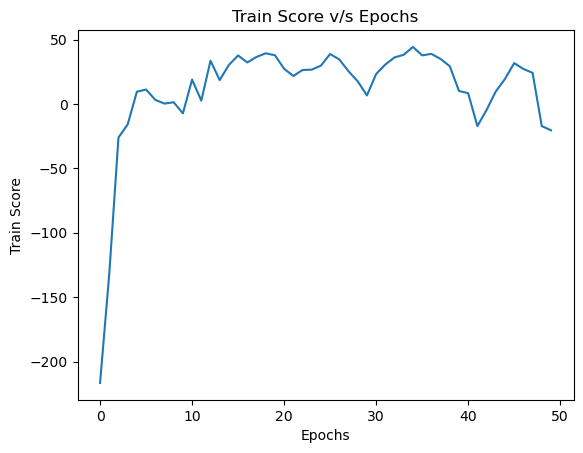

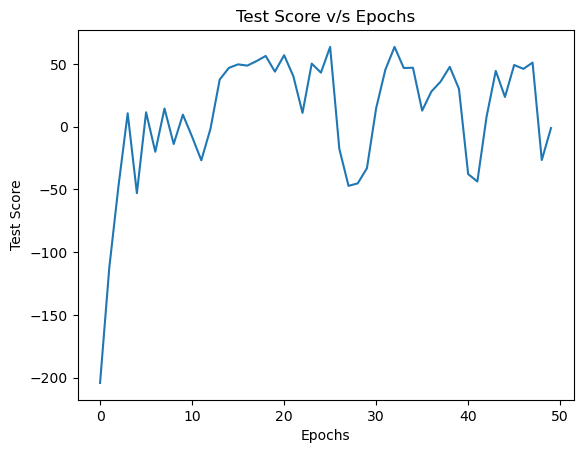

Training finished. It's time to watch!
Total score:  54.0
Total score:  47.0
Total score:  71.0
Total score:  63.0
Total score:  -47.0
Total score:  -104.0
Total score:  22.0
Total score:  -2.0
Total score:  82.0
Total score:  -13.0


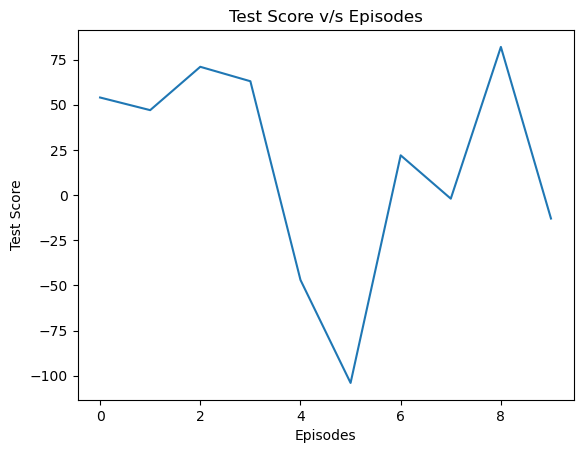

In [1]:

if __name__ == "__main__":
    # Initialize game and actions
    game = create_simple_game()
    n = game.get_available_buttons_size()
    actions = [list(a) for a in it.product([0, 1], repeat=n)]

    # Initialize our agent with the set parameters
    agent = DQNAgent(
        len(actions),
        lr=learning_rate,
        batch_size=batch_size,
        memory_size=replay_memory_size,
        discount_factor=discount_factor,
        load_model=load_model,
    )

    # Run the training for the set number of epochs
    if not skip_learning:
        agent, game = run(
            game,
            agent,
            actions,
            num_epochs=train_epochs,
            frame_repeat=frame_repeat,
            steps_per_epoch=learning_steps_per_epoch,
        )

        print("======================================")
        print("Training finished. It's time to watch!")

    # Reinitialize the game with window visible
    game.close()
    game.set_window_visible(True)

    game.set_mode(vzd.Mode.ASYNC_PLAYER)
    game.init()
    scores=[]
    for _ in range(episodes_to_watch):
        game.new_episode()
        while not game.is_episode_finished():
            state = preprocess(game.get_state().screen_buffer)
            best_action_index = agent.get_action(state)

            # Instead of make_action(a, frame_repeat) in order to make the animation smooth
            game.set_action(actions[best_action_index])
            for _ in range(frame_repeat):
                game.advance_action()

        # Sleep between episodes
        sleep(1.0)
        score = game.get_total_reward()
        print("Total score: ", score)
        scores.append(score)
    plot([i for i in range(0, episodes_to_watch)],scores,"Test Score v/s Episodes", "Episodes", "Test Score")
